<a href="https://colab.research.google.com/github/davemlz/eemont/blob/master/tutorials/014-Time-Series-By-Regions-Pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series By Regions (with Conversion to Pandas and Visualization with Seaborn) using EEMONT, GEETOOLS and GEEMAP

- GitHub Repo: [https://github.com/davemlz/eemont](https://github.com/davemlz/eemont)
- PyPI link: [https://pypi.org/project/eemont/](https://pypi.org/project/eemont/)
- Documentation: [https://eemont.readthedocs.io/en/0.1.8/index.html](https://eemont.readthedocs.io/en/0.1.8/index.html)
- More tutorials: [https://github.com/davemlz/eemont/tree/master/tutorials](https://github.com/davemlz/eemont/tree/master/tutorials)

## Let's start!

NOTE: before running this notebook, pass the following commands to a Python terminal. (File, New, Terminal)

In [1]:
!yes | mamba install eemont -q

yes: standard output: Broken pipe


Return to this notebook and Import the required packges.

In [3]:
import ee, geemap
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import eemont

# import geetools for cloud /shadow discrimination
# from geetools import ui, cloud_mask


Authenticate and Initialize Earth Engine and geemap.

In [4]:
Map = geemap.Map()
Map.add_basemap('Esri.WorldImagery')
Map


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Let's use some center-pivot crops in Utah:

In [5]:
pivot0=ee.Geometry.Point([-113.663642,37.682951]).buffer(500) #the number in buffer is the radius for the center pivot
pivot1=ee.Geometry.Point([-113.698426,37.623206]).buffer(400)
pivot2=ee.Geometry.Point([-113.642373,37.732786]).buffer(400)

Map.addLayer(pivot0,{},'pivot0')
Map.addLayer(pivot1,{},'pivot1')
Map.addLayer(pivot2,{},'pivot2')

Map.centerObject(pivot0,12)
Map

Map(center=[37.68295151294841, -113.66364198203783], controls=(WidgetControl(options=['position', 'transparent…

Let's combine the different center pivot features into a Feature Collection

In [6]:
pivots = ee.FeatureCollection([
    ee.Feature(pivot0,{'pivot':0}),
    ee.Feature(pivot1,{'pivot':1}),
    ee.Feature(pivot2,{'pivot':2})    
])

Let's pre-process and process our image collection; LANDSAT 8

First let's create a Landsat 8 snow pixel filter

In [7]:
def maskSnow(image):
# // to Landsat 8 imagery.
    N = image.select('B5')
    G = image.select('B3')
    NDSI =image.normalizedDifference(['B3', 'B6'])
    # https://eemont.readthedocs.io/en/latest/tutorials/006-NDSI-and-Snow-Cover-Sentinel-2-MOD10A2.html?highlight=snow%20mask#Overloaded-Operators
    snowPixels = (NDSI > 0.4) & (N >= 0.1) & (G > 0.11)
    return image.updateMask(~snowPixels)

process landsat and apply maskSnow

In [8]:
L8 = (ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
      .filterBounds(pivots)
      .maskClouds()
      .scaleAndOffset()
      .spectralIndices(['NDVI','NDWI','GVMI'])).map(maskSnow)

The list of available indices in eemont can be retrieved by running (check this list to get details on the implemented indexes https://eemont.readthedocs.io/en/latest/guide/spectralIndices.html):

In [9]:
eemont.listIndices()

['AFRI1600',
 'AFRI2100',
 'ANDWI',
 'ARI',
 'ARI2',
 'ARVI',
 'ATSAVI',
 'AVI',
 'AWEInsh',
 'AWEIsh',
 'BAI',
 'BAIM',
 'BAIS2',
 'BCC',
 'BI',
 'BITM',
 'BIXS',
 'BLFEI',
 'BNDVI',
 'BRBA',
 'BWDRVI',
 'BaI',
 'CIG',
 'CIRE',
 'CSI',
 'CSIT',
 'CVI',
 'DBI',
 'DBSI',
 'DPDD',
 'DSI',
 'DSWI1',
 'DSWI2',
 'DSWI3',
 'DSWI4',
 'DSWI5',
 'DVI',
 'DVIplus',
 'DpRVIHH',
 'DpRVIVV',
 'EBBI',
 'EMBI',
 'EVI',
 'EVI2',
 'ExG',
 'ExGR',
 'ExR',
 'FCVI',
 'GARI',
 'GBNDVI',
 'GCC',
 'GDVI',
 'GEMI',
 'GLI',
 'GM1',
 'GM2',
 'GNDVI',
 'GOSAVI',
 'GRNDVI',
 'GRVI',
 'GSAVI',
 'GVMI',
 'IAVI',
 'IBI',
 'IKAW',
 'IPVI',
 'IRECI',
 'LSWI',
 'MBI',
 'MBWI',
 'MCARI',
 'MCARI1',
 'MCARI2',
 'MCARI705',
 'MCARIOSAVI',
 'MCARIOSAVI705',
 'MGRVI',
 'MIRBI',
 'MLSWI26',
 'MLSWI27',
 'MNDVI',
 'MNDWI',
 'MNLI',
 'MRBVI',
 'MSAVI',
 'MSI',
 'MSR',
 'MSR705',
 'MTCI',
 'MTVI1',
 'MTVI2',
 'MuWIR',
 'NBAI',
 'NBLI',
 'NBR',
 'NBR2',
 'NBRSWIR',
 'NBRT1',
 'NBRT2',
 'NBRT3',
 'NBRplus',
 'NBSIMS',
 'NBUI',
 '

Let's check which bands are available.

In [10]:
L8.first().bandNames().getInfo()

['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B10',
 'B11',
 'sr_aerosol',
 'pixel_qa',
 'radsat_qa',
 'NDVI',
 'NDWI',
 'GVMI']

## Time Lapse of the Satellite data

Using Geemap example 72

In [11]:
collection = L8.select("NDVI").filter(ee.Filter.date('2021-01-01', '2021-12-31')).sort('system:time_start')

vis_params = {
  'min': 0.0,
  'max': 1.0,
  'palette': [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301'
  ],
}

first_image = collection.first()

Map.addLayer(first_image, vis_params, "First image")
# Map.setCenter(-7.03125, 31.0529339857, 2)
Map

Map(center=[37.68295151294841, -113.66364198203783], controls=(WidgetControl(options=['position', 'transparent…

In [12]:
# image = collection.toBands()
# Map.addLayer(image, {}, "Time series", False)

In [35]:
labels = collection.aggregate_array("system:index").getInfo()
Map.add_time_slider(collection, vis_params, labels=labels, time_interval=1)
Map

Map(bottom=1623197.0, center=[37.658751368732155, -113.6433506011963], controls=(WidgetControl(options=['posit…

## Time Series By Regions

Let's get the L8 time series for our buffer. Checklist:

- Image Collection: The Landsat 8 collection.
- Bands to use for the time series: GNDVI and EVI.
- Feature Collection: Our center-pivot crops.
- Statistics to compute: Mean and Median.
- Scale: 30 m.

In [36]:
ts = L8.getTimeSeriesByRegions(collection = pivots,
                               bands = ['NDVI','NDWI','GVMI'],
                               reducer = [ee.Reducer.mean()], #ee.Reducer.median()
                               scale = 30)

## Conversion to Pandas

The time series is retrieved as a feature collection. To convert it to a pandas dataframe we'll use `geemap` (This may take a little bit):

In [15]:
tsPandas = geemap.ee_to_pandas(ts)

Let's check our pandas data frame:

In [16]:
tsPandas

,date,B4,B5,pivot,reducer,NDVI
0,2013-03-29T18:11:42,0.239893,0.316394,0,mean,0.137762
1,2013-03-29T18:11:42,0.142119,0.290962,1,mean,0.343453
2,2013-03-29T18:11:42,0.177749,0.339646,2,mean,0.313492
3,2013-04-22T18:10:46,0.253788,0.337367,0,mean,0.141594
4,2013-04-22T18:10:46,0.066927,0.424787,1,mean,0.727673
...,...,...,...,...,...,...
1150,2021-12-15T18:15:31,-9999.000000,-9999.000000,1,mean,-9999.000000
1151,2021-12-15T18:15:31,-9999.000000,-9999.000000,2,mean,-9999.000000
1152,2021-12-31T18:15:25,-9999.000000,-9999.000000,0,mean,-9999.000000
1153,2021-12-31T18:15:25,-9999.000000,-9999.000000,1,mean,-9999.000000


What can we see here?

- The values for each band (NDWI, NDVI and CVI) are in separated columns.
- There are some -9999 values in the NDWI, NDVI and CVI columns. These values represent the NA values (e.g. Clouds or shadows). The -9999 can be changed by modifying the `naValue` parameter in the `getTimeSeriesByRegion` method (e.g. `naValue = -10000`).
- Multiple reducers can be used. In the output dataframe they are specified by a single column named `reducer`: mean, median.
- The date is a string that needs to be converted to a date data type.
- The attributes of the original feature collection are attached to the data frame: `pivot`.

Given this, let's curate our data frame!

First, let's get rid of the -9999 value:

In [17]:
tsPandas[tsPandas == -9999] = np.nan

And now, let's convert the date to a date data type:

In [18]:
tsPandas['date'] = pd.to_datetime(tsPandas['date'],infer_datetime_format = True)

We can also gather the GNDVI and EVI columns into a single column to make the data frame more 'tidy-er' (This is optional):

In [34]:
tsPandas = pd.melt(tsPandas,
                   id_vars = ['reducer','date','pivot'],
                   value_vars = ['NDVI','NDWI','GVMI'],
                   var_name = 'Index',
                   value_name = 'Value')

ValueError: value_name (Value) cannot match an element in the DataFrame columns.

Let's check our curated data frame:

In [20]:
# tsPandas[tsPandas['Value'] > 1] = np.nan
# tsPandas[tsPandas['Value'] < 0] = np.nan

tsPandas

,reducer,date,pivot,Index,Value
0,mean,2013-03-29 18:11:42,0,NDVI,0.137762
1,mean,2013-03-29 18:11:42,1,NDVI,0.343453
2,mean,2013-03-29 18:11:42,2,NDVI,0.313492
3,mean,2013-04-22 18:10:46,0,NDVI,0.141594
4,mean,2013-04-22 18:10:46,1,NDVI,0.727673
...,...,...,...,...,...
3460,mean,2021-12-15 18:15:31,1,B5,NaN
3461,mean,2021-12-15 18:15:31,2,B5,NaN
3462,mean,2021-12-31 18:15:25,0,B5,NaN
3463,mean,2021-12-31 18:15:25,1,B5,NaN


## Visualization

Now, let's visualize our time series using `seaborn`:

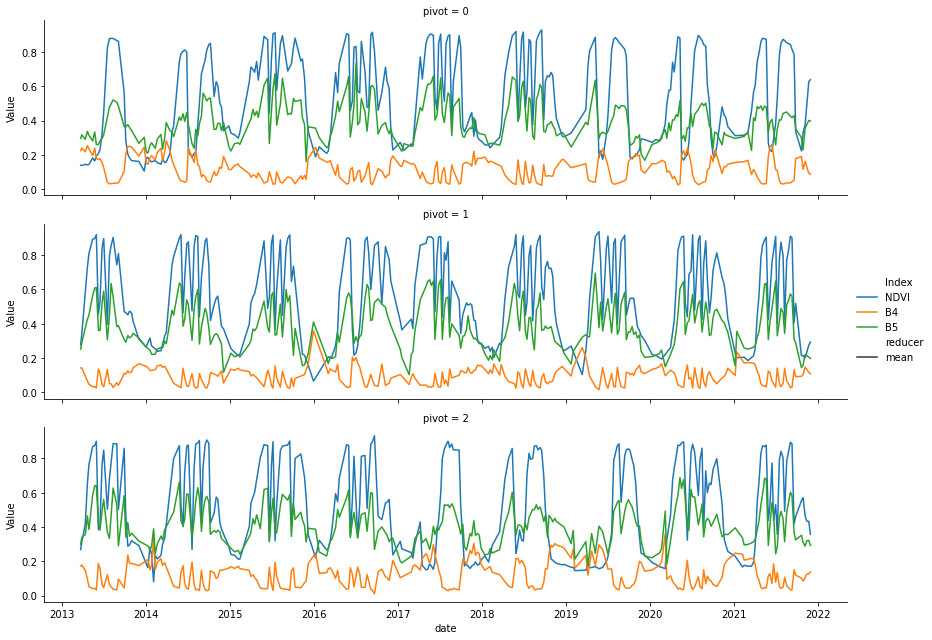

In [21]:
g = sns.FacetGrid(tsPandas,row = 'pivot',height = 3,aspect = 4)
g.map_dataframe(sns.lineplot,x = 'date',y = 'Value',hue = 'Index',style = 'reducer')
g.add_legend()

Let's do the same, but now for radiometric temperature (two bands, B10 and B11).

In [22]:
ts = L8.getTimeSeriesByRegions(collection = pivots,
                               bands = ['B10'],
                               reducer = [ee.Reducer.mean()],
                               scale = 30)

In [23]:
tsPandas2 = geemap.ee_to_pandas(ts)

In [24]:
tsPandas2

,date,B10,pivot,reducer
0,2013-03-29T18:11:42,306.408830,0,mean
1,2013-03-29T18:11:42,303.716339,1,mean
2,2013-03-29T18:11:42,303.921917,2,mean
3,2013-04-22T18:10:46,307.296102,0,mean
4,2013-04-22T18:10:46,297.388625,1,mean
...,...,...,...,...
1150,2021-12-15T18:15:31,NaN,1,mean
1151,2021-12-15T18:15:31,NaN,2,mean
1152,2021-12-31T18:15:25,NaN,0,mean
1153,2021-12-31T18:15:25,NaN,1,mean


In [25]:
tsPandas2[tsPandas2 == -9999] = np.nan

tsPandas2['date'] = pd.to_datetime(tsPandas2['date'],infer_datetime_format = True)

In [26]:
tsPandas2 = pd.melt(tsPandas2,
                   id_vars = ['reducer','date','pivot'],
                   value_vars = ['B10'],
                   var_name = 'Index',
                   value_name = 'Value')

In [27]:
tsPandas2

,reducer,date,pivot,Index,Value
0,mean,2013-03-29 18:11:42,0,B10,306.408830
1,mean,2013-03-29 18:11:42,1,B10,303.716339
2,mean,2013-03-29 18:11:42,2,B10,303.921917
3,mean,2013-04-22 18:10:46,0,B10,307.296102
4,mean,2013-04-22 18:10:46,1,B10,297.388625
...,...,...,...,...,...
1150,mean,2021-12-15 18:15:31,1,B10,NaN
1151,mean,2021-12-15 18:15:31,2,B10,NaN
1152,mean,2021-12-31 18:15:25,0,B10,NaN
1153,mean,2021-12-31 18:15:25,1,B10,NaN


Visualization

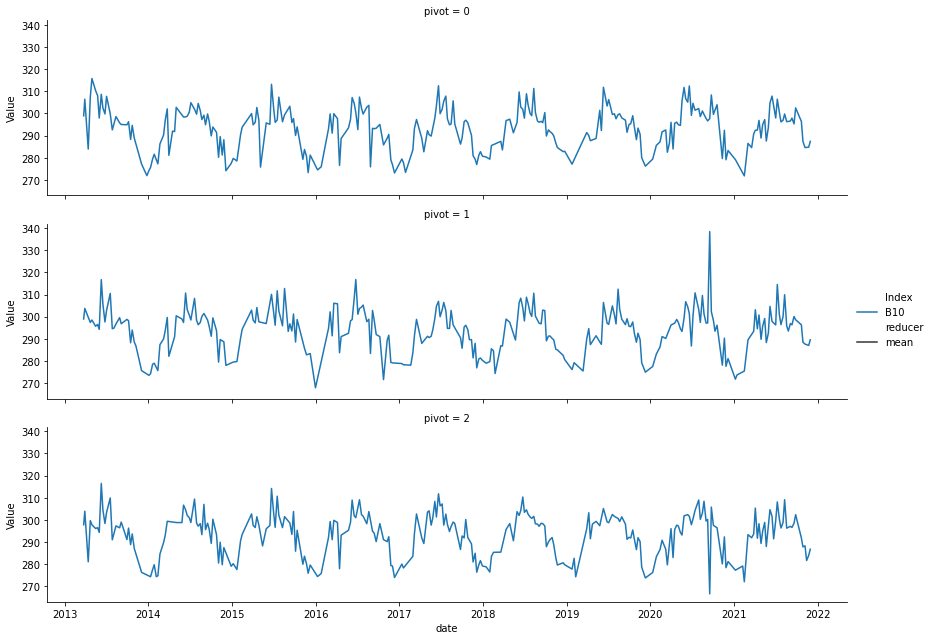

In [28]:
g = sns.FacetGrid(tsPandas2,row = 'pivot',height = 3,aspect = 4)
g.map_dataframe(sns.lineplot,x = 'date',y = 'Value',hue = 'Index',style = 'reducer')
g.add_legend()

Is there any relationship between NDVI and temperature?

In [29]:
dfinal = tsPandas.merge(tsPandas2, on=['date','reducer','pivot'])
dfinal

,reducer,date,pivot,Index_x,Value_x,Index_y,Value_y
0,mean,2013-03-29 18:11:42,0,NDVI,0.137762,B10,306.408830
1,mean,2013-03-29 18:11:42,0,B4,0.239893,B10,306.408830
2,mean,2013-03-29 18:11:42,0,B5,0.316394,B10,306.408830
3,mean,2013-03-29 18:11:42,1,NDVI,0.343453,B10,303.716339
4,mean,2013-03-29 18:11:42,1,B4,0.142119,B10,303.716339
...,...,...,...,...,...,...,...
3460,mean,2021-12-31 18:15:25,1,B4,NaN,B10,NaN
3461,mean,2021-12-31 18:15:25,1,B5,NaN,B10,NaN
3462,mean,2021-12-31 18:15:25,2,NDVI,NaN,B10,NaN
3463,mean,2021-12-31 18:15:25,2,B4,NaN,B10,NaN


In [30]:
select_color = dfinal.loc[(dfinal['Index_x'] == 'NDVI') & (dfinal['Index_y'] == 'B10') & (dfinal['pivot'] == 0)& (dfinal['reducer'] == 'mean')]
select_color

,reducer,date,pivot,Index_x,Value_x,Index_y,Value_y
0,mean,2013-03-29 18:11:42,0,NDVI,0.137762,B10,306.408830
9,mean,2013-04-22 18:10:46,0,NDVI,0.141594,B10,307.296102
18,mean,2013-05-24 18:11:02,0,NDVI,0.164506,B10,307.978358
27,mean,2013-06-09 18:11:00,0,NDVI,0.207524,B10,308.635887
36,mean,2013-06-25 18:10:56,0,NDVI,0.324716,B10,299.764536
...,...,...,...,...,...,...,...
3420,mean,2021-10-28 18:15:36,0,NDVI,0.329083,B10,287.344539
3429,mean,2021-11-13 18:15:32,0,NDVI,NaN,B10,NaN
3438,mean,2021-11-29 18:15:32,0,NDVI,0.638640,B10,287.381068
3447,mean,2021-12-15 18:15:31,0,NDVI,NaN,B10,NaN


<AxesSubplot: title={'center': 'Center Pivot 0'}, xlabel='B10', ylabel='NDVI'>

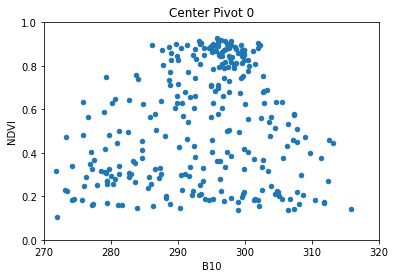

In [31]:
select_color.plot(kind='scatter',x="Value_y",y="Value_x",title="Center Pivot 0",xlim=(270,320),ylim=(0,1),xlabel='B10',ylabel='NDVI')

<AxesSubplot: title={'center': 'Center Pivot 0'}, xlabel='B10', ylabel='NDWI'>

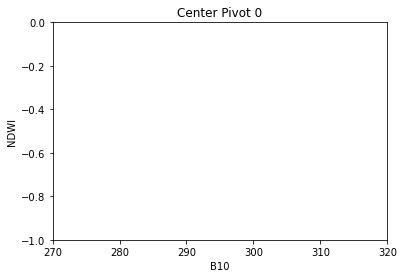

In [32]:
select_color = dfinal.loc[(dfinal['Index_x'] == 'NDWI') & (dfinal['Index_y'] == 'B10') & (dfinal['pivot'] == 0)& (dfinal['reducer'] == 'mean')]
select_color.plot(kind='scatter',x="Value_y",y="Value_x",title="Center Pivot 0",xlim=(270,320),ylim=(-1,0),xlabel='B10',ylabel='NDWI')


<AxesSubplot: title={'center': 'Center Pivot 0'}, xlabel='B10', ylabel='GVMI'>

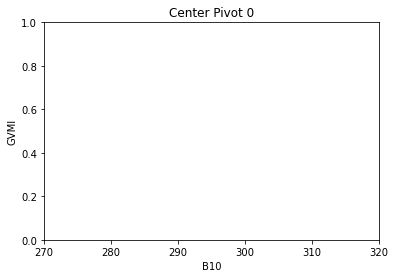

In [33]:
select_color = dfinal.loc[(dfinal['Index_x'] == 'GVMI') & (dfinal['Index_y'] == 'B10') & (dfinal['pivot'] == 0)& (dfinal['reducer'] == 'mean')]
select_color.plot(kind='scatter',x="Value_y",y="Value_x",title="Center Pivot 0",xlim=(270,320),ylim=(0,1),xlabel='B10',ylabel='GVMI')

## Assignment:
    
Create two notebooks, and in each notebook, change the center pivot locations, for the first one, select 3 center pivots around "El Amal, Markaz Abo El Matamier, Beheira" (Egypt) and the second notebook select 3 center pivots around  "Seminole, Texas". Please, discuss the time series variability in vegetation indices and temperatures between the two notebooks. What could be reasons for the found differences?

Happy Coding!
